Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**IMPORTANT: DO NOT COPY OR SPLIT CELLS.** If you do, you'll mess the autograder. If need more cells to work or test things out, create a new cell. You may add as many new cells as you need.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and group below:

In [50]:
COURSE = "Unsupervised Learning 2021"
GROUP = "D8A"
NAME = "Tokiyomi" # Match your GitHub Classroom ID

---

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Density based clustering

In this assignment we will implement the DBSCAN algortuhm and compare it with the official Python implementation on HDBSCAN. We'll test our algorithms with the synthetic data from the HDBSCAN python implementation. This data set has 6 natural non-isotropic clusters of different densities, plus noise.

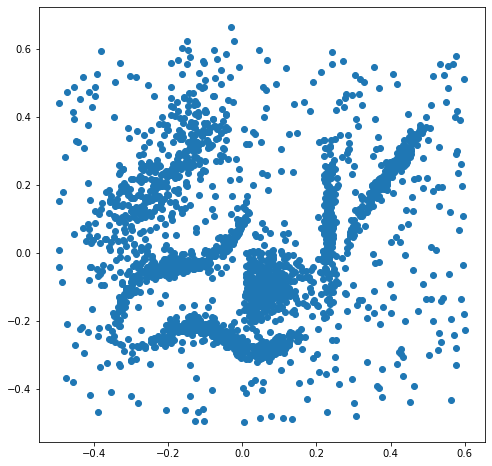

In [52]:
X = np.load('clusterable_data.npy')
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1]);

In [53]:
X

array([[-0.12153499, -0.22876337],
       [-0.22093687, -0.25251088],
       [ 0.1259037 , -0.27314321],
       ...,
       [ 0.50243143, -0.3002958 ],
       [ 0.53822256,  0.19412199],
       [-0.08688887, -0.2092721 ]])

In [54]:
np.linalg.norm(X[1]-X[0])

0.10219920987971746

In [55]:
np.where(np.linalg.norm(X[0]- X, axis=1)[1:] > 0.25)

(array([   1,  311,  314, ..., 2304, 2305, 2306], dtype=int64),)

## DBSCAN, neighborhood function (4 points) 

In [56]:
# To find wether a point is a core point or not, we need to find its neighborhood.
# Implement such function below.
#@njit
def eps_neighborhood(i, X, e):
    """ Returns indices of all points whose distance to X[i] is less than e."""
    # distances
    distances = np.linalg.norm(X[i]-X, axis = 1)
    
    # including self distance
    indexes = np.where(distances <= e)
    
    return indexes[0]

Compare the results with the plots in the lecture notes.

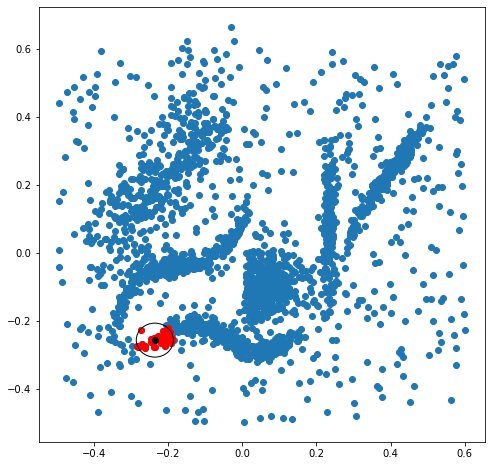

In [57]:
x_idx = 100
e=0.05
nn = eps_neighborhood(x_idx, X, e)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[nn][:,0], X[nn][:,1], c='r')
plt.scatter(X[x_idx][0], X[x_idx][1], c='k')
circle = plt.Circle((X[x_idx][0], X[x_idx][1]),radius=e, fill=False)
ax=plt.gca()
ax.add_patch(circle)

In [58]:
nn # se incluye a si mismo

array([   1,   19,   25,   37,   42,   47,   50,   53,   57,   62,   67,
         72,   74,   87,  100,  104,  111,  117,  118,  125,  128,  145,
        146,  160,  164,  172,  181,  189,  203,  208,  212,  214,  216,
        220,  228,  242,  245, 2061], dtype=int64)

## DBSCAN, grow cluster function (4 points) 

In [59]:
# We now need a function to grow a cluster.
# Implement a function that starts at a core point and finds all density reachable points from it, 
# and adds them to the cluster.
#@njit
def grow_cluster(i, X, e, q, labels, m):
    """ Starts at core point X[i] and finds all density connected points to it.
        INPUTS:
            i: index of seed point
            X: data matrix
            e: neighbor radius
            q: min points in neighborhood to be considered core point
            labels: list of cluster labels
            m: current cluster label
        OUTPUTS:
            number of points in new cluster
            
        To implement this function try to build up a FIFO queu. Start your queue 
        with the intial neighbors, then test each neighbor to know wether is a core point or not.
        If the neighbor is a core point add its neighbors to the queue, else do nothing as it is a boundary point.
        
        The queu will grow with each new core point's neighbors, until all density connected points are tested.
    """
    
    # Append i to cluster
    labels[i] = m
    
    # Create a FIFO list to queu potential new core points to test.
    queu = list(eps_neighborhood(i, X, e))
        
    # For each point in queu, search its neighborhood, and new core points to queu.
    j = 0

    while j < len(queu):

        # reachable neighs
        n = list(eps_neighborhood(queu[j], X, e))

        if len(n) >= q:
            # add neighs to the queu
            nuevos =  set(n) - set(queu) 
            queu += list(nuevos)

            # assign labels to all reachable points
            labels[n] = m

        j += 1 
    
    # return size of cluster, just to return a value
    return len(queu)

Again, compare the results with the plots on the lecture notes.

Cluster size obtained: 403, should be 8993


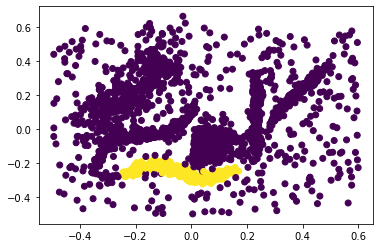

In [60]:
labels = np.zeros(len(X))
size = grow_cluster(100, X, 0.02, 5, labels, 1)
plt.scatter(X[:,0], X[:,1], c=labels)
print(f'Cluster size obtained: {size}, should be {8993}')

## Combining both function into the DBSCAN algorithm

We reproduce the same function provided in the notes for convinience. Refer to the notes for a discussion of the algorithm.

In [61]:
#@njit
def dbscan(X, e, q):
    """ The DBSCAN algorithm. Unoptimized implementation with pedagogical purposes.
        
        INPUTS:
                -X: data matrix
                -e: epsilon, the neighbor radius arround each point
                -q: The minimum number of points for a cluster to be dense
    """
    
    n, d = X.shape
    # Array to hold cluster assignments: 0 is not considered, -1 is noise
    # You need to return this array correctly
    labels = np.zeros(n)
    
    # Current cluster label
    m = 0
    
    # Instead of using sets, well just iterate over every point in order.
    # If you want to choose at random, you can shuffle X before starting.
    # I don't beleive it makes a difference
    for i, x in enumerate(X):
        if labels[i] != 0:
            # Point already in another cluster
            continue
        nbrs = eps_neighborhood(i, X, e)
        if len(nbrs) < q:
            # Is a noise point (so far, can be claimed later.)
            labels[i] = -1
            continue
        # else, x is a core point
        m += 1
        m_size = grow_cluster(i, X, e, q, labels, m)
        
    return labels

Compare results with lecture notes.

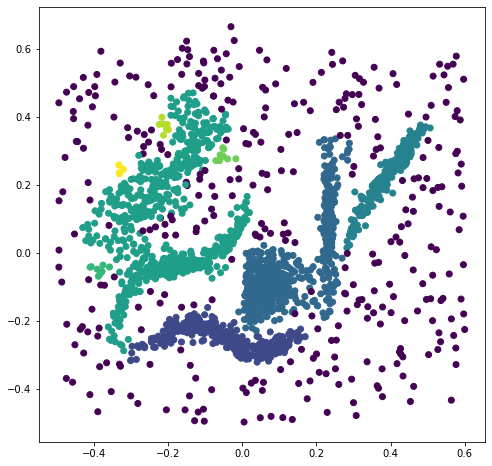

In [62]:
# Now test different values of e and q.
# A good choice seems to be e = 0.025 and q = 4.
labels = dbscan(X, 0.025, 5)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels);

In [63]:
np.unique(labels)

array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

## HDBSCAN (2 points)

Watch video, read documentation. Then try HDBSCAN with the same sample dataset. Compare.

In [64]:
# Write your code here, add cells if needed.
import hdbscan

In [65]:
# had to use: conda install -c conda-forge hdbscan

In [66]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                 min_samples=10)

In [67]:
clusterer.fit(X)

HDBSCAN(min_cluster_size=20, min_samples=10)

In [68]:
clusterer.labels_

array([ 4,  4,  4, ..., -1, -1,  4], dtype=int64)

In [69]:
clusterer.labels_.max()

5

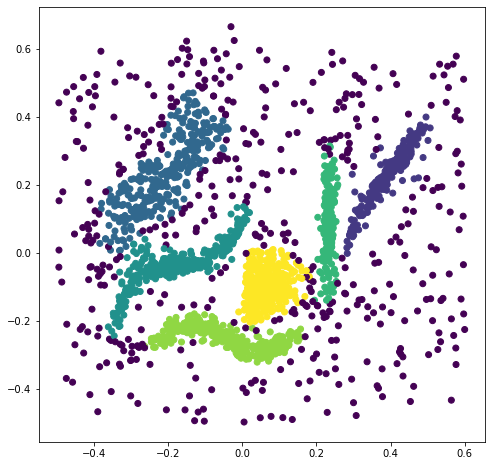

In [70]:
labels = clusterer.labels_
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels);

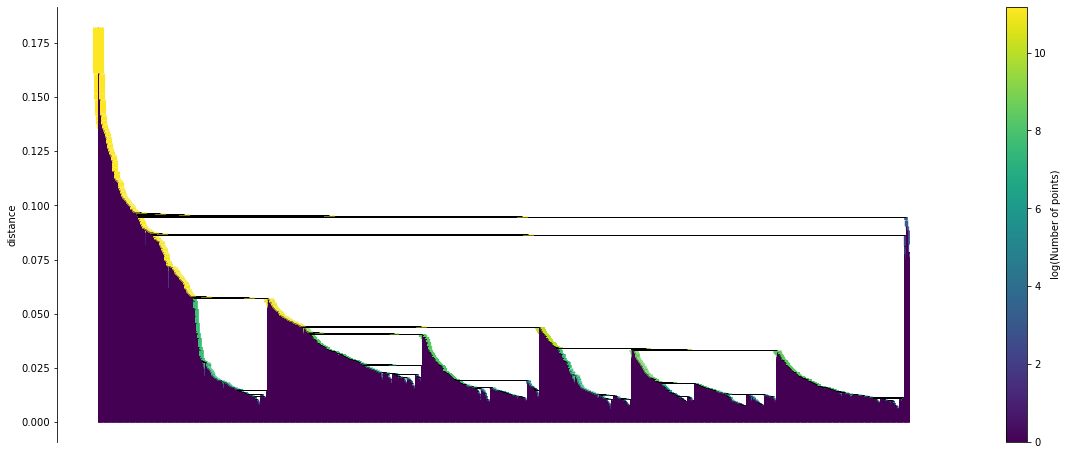

In [71]:
plt.figure(figsize=(20,8))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

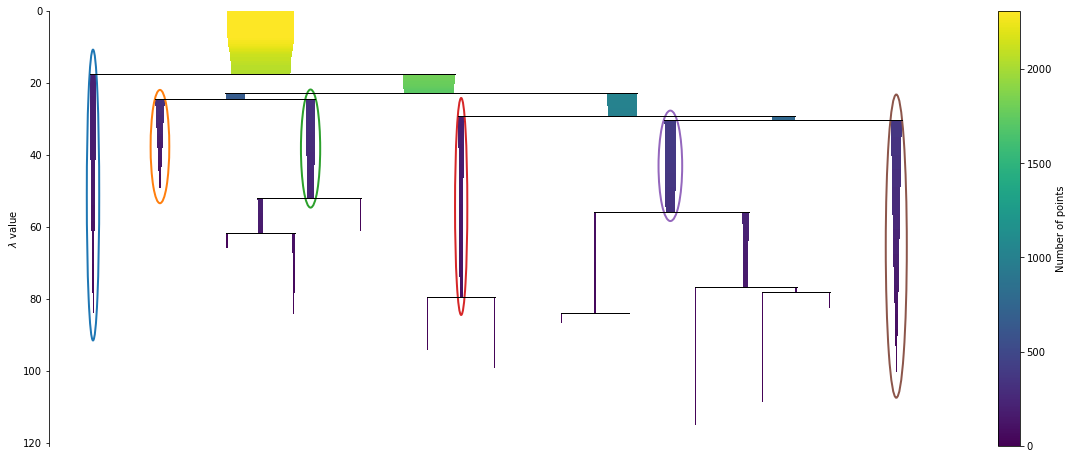

In [72]:
plt.figure(figsize=(20,8))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()